##데이터 불러오기

In [37]:
import pandas as pd
import numpy as np
import seaborn as sns

df_origin = pd.read_csv("https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/vgames2.csv")
df = df_origin
df.head()

,Unnamed: 0,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,1,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,2,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,4,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04


In [38]:
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import matplotlib as mpl

# 폰트 변환
# Windows
# mpl.rc("font", family='Malgun Gothic')

# MacOS
mpl.rc("font", family='AppleGothic')

# 마이너스 사인 수정
mpl.rc('axes', unicode_minus=False)

warnings.filterwarnings("ignore")
%matplotlib inline

# 첫번째 방법
%config InlineBackend.figure_format='retina'

# 두번째 방법
# from IPython.display import set_matplotlib_formats
# set_matplotlib_formats('retina')

# 둘 중 편한걸로 사용

## EDA

#### 데이터 타입 확인 및 변경

In [39]:
#데이터 확인
df.info()

#sales 값 object에서 float으로 타입 변경
df['NA_Sales'] = pd.to_numeric(df['NA_Sales'],errors = 'coerce') #coerce = 오류값 nan값으로 대체
df['EU_Sales'] = pd.to_numeric(df['EU_Sales'],errors = 'coerce')
df['JP_Sales'] = pd.to_numeric(df['JP_Sales'],errors = 'coerce')
df['Other_Sales'] = pd.to_numeric(df['Other_Sales'],errors = 'coerce')

#Total_sales 칼럼을 새로 만든다.
df['Total_sales'] = df['NA_Sales'] + df['EU_Sales'] + df['JP_Sales'] + df['Other_Sales']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   16598 non-null  int64  
 1   Name         16598 non-null  object 
 2   Platform     16598 non-null  object 
 3   Year         16327 non-null  float64
 4   Genre        16548 non-null  object 
 5   Publisher    16540 non-null  object 
 6   NA_Sales     16598 non-null  object 
 7   EU_Sales     16598 non-null  object 
 8   JP_Sales     16598 non-null  object 
 9   Other_Sales  16598 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 1.3+ MB


In [40]:
#Total_sales가 0인 행 확인
condition = df["Total_sales"]<=0
# print("Total_sales가 0인 행\n",df[condition].count(),"\n")
print("Sales 0값 제거 전 데이터:", df.shape)

#Total Sales가 0인 데이터도 삭제
df.drop(df.loc[df["Total_sales"] == 0].index, inplace = True) 
print("Sales 0값 제거 후 데이터:",df.shape,"\n")

#Year가 1900년도 이전의 값들 모두 제거
print("Year 오류값 제거 전 데이터:",df.shape)
# df.drop(df.loc[df["Total_sales"] == 0].index, inplace = True) 
df.drop(df[df["Year"] < 1900].index, inplace=True)
print("Year 오류값 제거 후 데이터:",df.shape)

Sales 0값 제거 전 데이터: (16598, 11)
Sales 0값 제거 후 데이터: (16597, 11) 

Year 오류값 제거 전 데이터: (16597, 11)
Year 오류값 제거 후 데이터: (16497, 11)


#### 결측치 확인 및 제거

In [41]:
#결측치 확인
print("결측치:\n",df.isnull().sum(),"\n") 

print("결측치 제거 전 데이터:",df.shape)

df = df.drop(df.columns[[0]], axis=1) #첫번째 열 제거
df = df.dropna(axis = 0) #결측치가 포함된 모든 행 제거
df = df.reset_index(level=None, drop=True, inplace=False, col_level=0, col_fill='') #인덱스 reset

print("결측치 제거 후 데이터:",df.shape)

결측치:
 Unnamed: 0       0
Name             0
Platform         0
Year           271
Genre           50
Publisher       58
NA_Sales       197
EU_Sales       198
JP_Sales       198
Other_Sales    200
Total_sales    779
dtype: int64 

결측치 제거 전 데이터: (16497, 11)
결측치 제거 후 데이터: (15381, 10)


#### 중복 데이터 값 확인 및 제거

In [42]:
#duplicated 게임이름 검색하여 확인
df.duplicated().sum()

#모든 값이 동일한 데이터가 없기 때문에 제거 대상 없음

0

##지역에 따라서 선호하는 게임 장르

NA_Sales: 11204
EU_Sales: 10083
JP_Sales: 5725
Other_Sales: 9424 

NA_Sales       4055.22
EU_Sales       2251.70
JP_Sales       1192.14
Other_Sales     743.86
dtype: float64


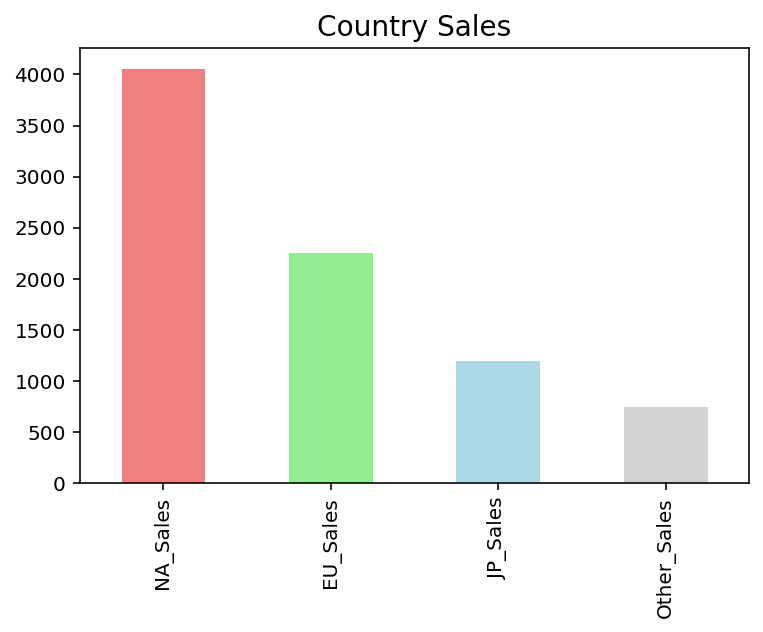

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
Genre,,,,
Action,801.89,486.60,149.85,176.14
Sports,633.87,349.85,126.65,126.13
Shooter,544.63,293.38,36.53,96.68
Role-Playing,283.86,160.10,314.15,50.86
Platform,410.96,184.11,121.88,47.88
Misc,380.36,200.14,99.47,69.97
Racing,334.14,222.66,50.60,73.48
Fighting,210.51,94.18,82.58,34.33
Simulation,173.64,106.97,61.51,29.49


In [43]:
#지역별 sales값 확인
print("NA_Sales:",df[df["NA_Sales"] > 0].value_counts().sum())
print("EU_Sales:",df[df["EU_Sales"] > 0].value_counts().sum())
print("JP_Sales:",df[df["JP_Sales"] > 0].value_counts().sum())
print("Other_Sales:",df[df["Other_Sales"] > 0].value_counts().sum(),"\n")

df_hist_area = df[["NA_Sales","EU_Sales","JP_Sales","Other_Sales"]].sum()
print(df_hist_area)

df_hist_area.plot.bar(color=["lightcoral","lightgreen","lightblue","lightgray"])
plt.title('Country Sales',fontsize=14) ## 타이틀 출력
plt.show()

#지역별 국가가 선호하는 장르 순위(출고량 합산 값)
df.groupby(["Genre"],axis=0, sort = True).sum().sort_values(by = ["Total_sales"],ascending = False)[["NA_Sales","EU_Sales","JP_Sales","Other_Sales"]].head(10)

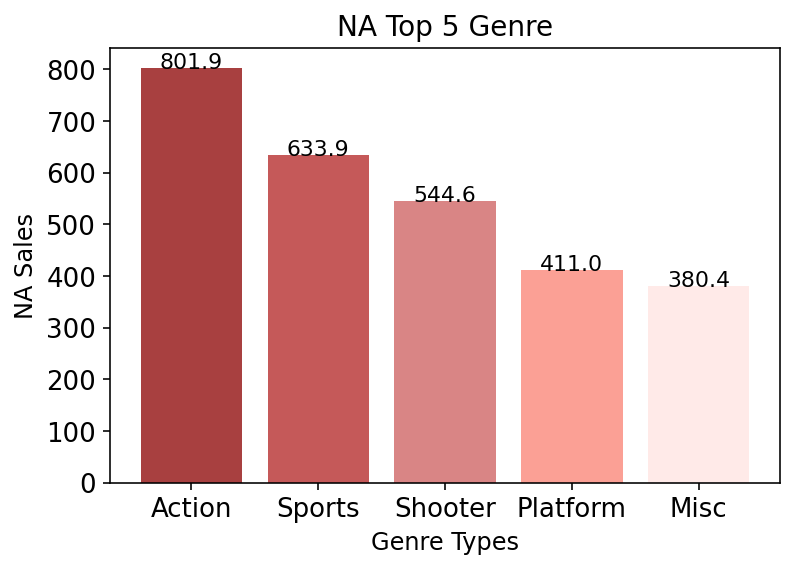

In [44]:
#미국이 선호하는 장르 순위(출고량 합산 값)
df_NA = df.groupby(["Genre"],axis=0, sort = True).sum()["NA_Sales"].sort_values(ascending = False).head(5)

## 시각화
tick_size = 13 ## 눈금 폰트 사이즈
axis_label_size = 12 ## x축, y축 폰트 사이즈
 
fig = plt.figure(figsize=(6,4)) ## Figure 생성 사이즈는 10 by 10
ax = fig.add_subplot() ## Axes 추가
# colors = sns.color_palette('hls',len(df_US)) ## 색상 지정
 
xtick_label_position = list(range(len(df_NA))) ## x축 눈금 라벨이 표시될 x좌표
 
plt.yticks(fontsize=tick_size)
plt.xticks(xtick_label_position, df_NA.index, fontsize=tick_size) ## x축 눈금 라벨 출력
 
bars = plt.bar(xtick_label_position, df_NA, color=["darkred","firebrick","indianred","salmon","mistyrose"], alpha=0.75, linewidth=3) ## 바차트 출력
 
for i, b in enumerate(bars):
    ax.text(b.get_x()+b.get_width()*(1/2),b.get_height()+0.1, \
            round(df_NA[i],1),ha='center',fontsize=11)
    
plt.title('NA Top 5 Genre',fontsize=14) ## 타이틀 출력
plt.xlabel('Genre Types',fontsize=axis_label_size) ## x축 라벨 출력
plt.ylabel('NA Sales',fontsize=axis_label_size) ## y축 라벨 출력
plt.show()

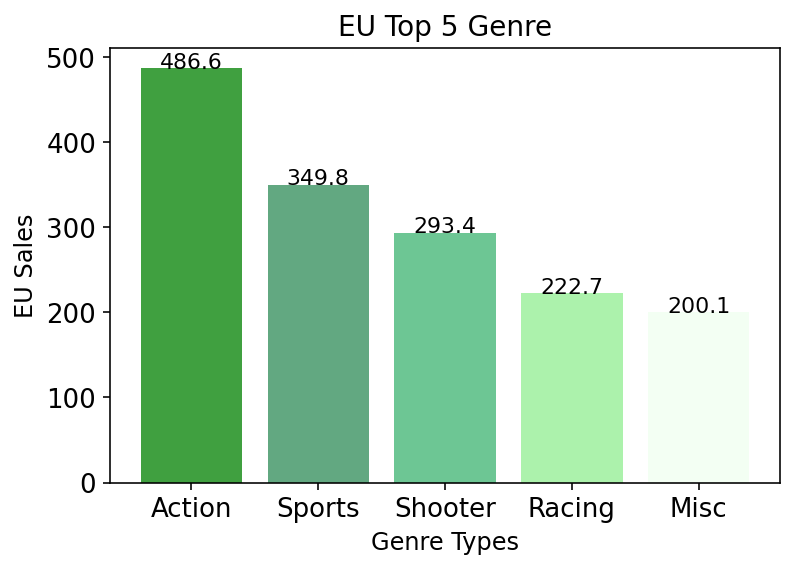

In [45]:
#유럽연합이 선호하는 장르 순위
df_EU = df.groupby(["Genre"],axis=0, sort = True).sum()["EU_Sales"].sort_values(ascending = False).head(5)

## 시각화
tick_size = 13 ## 눈금 폰트 사이즈
axis_label_size = 12 ## x축, y축 폰트 사이즈
 
fig = plt.figure(figsize=(6,4)) ## Figure 생성 사이즈는 10 by 10
ax = fig.add_subplot() ## Axes 추가
# colors = sns.color_palette('hls',len(df_EU)) ## 색상 지정
 
xtick_label_position = list(range(len(df_EU))) ## x축 눈금 라벨이 표시될 x좌표
 
plt.yticks(fontsize=tick_size)
plt.xticks(xtick_label_position, df_EU.index, fontsize=tick_size) ## x축 눈금 라벨 출력
 
bars = plt.bar(xtick_label_position, df_EU, color=["green","seagreen","mediumseagreen","lightgreen","honeydew"], alpha=0.75, linewidth=3) ## 바차트 출력
 
for i, b in enumerate(bars):
    ax.text(b.get_x()+b.get_width()*(1/2),b.get_height()+0.1, \
            round(df_EU[i],1),ha='center',fontsize=11)
    
plt.title('EU Top 5 Genre',fontsize=14) ## 타이틀 출력
plt.xlabel('Genre Types',fontsize=axis_label_size) ## x축 라벨 출력
plt.ylabel('EU Sales',fontsize=axis_label_size) ## y축 라벨 출력
plt.show()

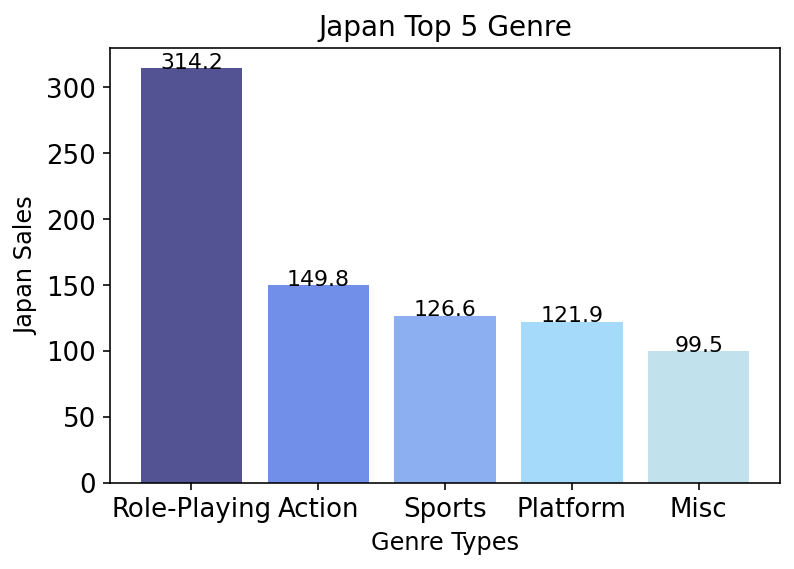

In [46]:
#일본이 선호하는 장르 순위
df_JP = df.groupby(["Genre"],axis=0, sort = True).sum()["JP_Sales"].sort_values(ascending = False).head(5)

## 시각화
tick_size = 13 ## 눈금 폰트 사이즈
axis_label_size = 12 ## x축, y축 폰트 사이즈
 
fig = plt.figure(figsize=(6,4)) ## Figure 생성 사이즈는 10 by 10
ax = fig.add_subplot() ## Axes 추가
# colors = sns.color_palette('hls',len(df_EU)) ## 색상 지정
 
xtick_label_position = list(range(len(df_JP))) ## x축 눈금 라벨이 표시될 x좌표
 
plt.yticks(fontsize=tick_size)
plt.xticks(xtick_label_position, df_JP.index, fontsize=tick_size) ## x축 눈금 라벨 출력
 
bars = plt.bar(xtick_label_position, df_JP, color=["midnightblue","royalblue","cornflowerblue","lightskyblue","lightblue"], alpha=0.75, linewidth=3) ## 바차트 출력
 
for i, b in enumerate(bars):
    ax.text(b.get_x()+b.get_width()*(1/2),b.get_height()+0.1, \
            round(df_JP[i],1),ha='center',fontsize=11)
    
plt.title('Japan Top 5 Genre',fontsize=14) ## 타이틀 출력
plt.xlabel('Genre Types',fontsize=axis_label_size) ## x축 라벨 출력
plt.ylabel('Japan Sales',fontsize=axis_label_size) ## y축 라벨 출력
plt.show()

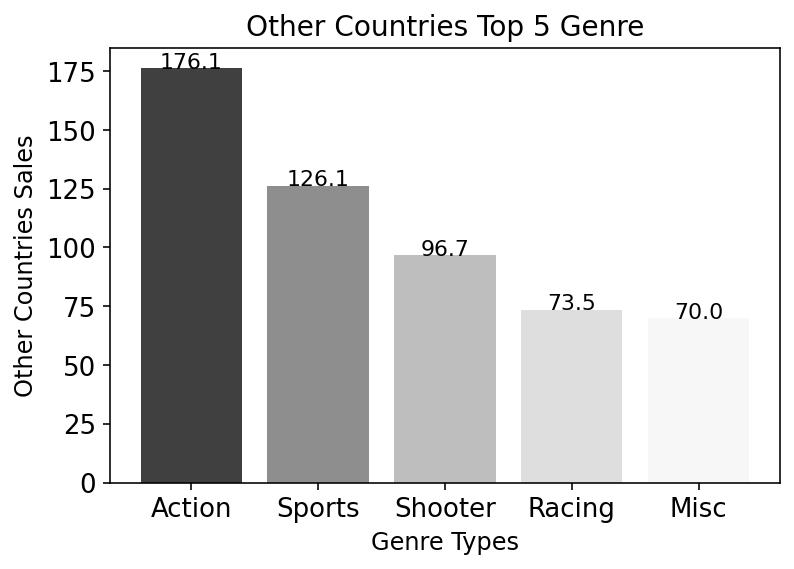

In [47]:
#유럽연합이 선호하는 장르 순위

df_Others = df.groupby(["Genre"],axis=0, sort = True).sum()["Other_Sales"].sort_values(ascending = False).head(5)

## 시각화
tick_size = 13 ## 눈금 폰트 사이즈
axis_label_size = 12 ## x축, y축 폰트 사이즈
 
fig = plt.figure(figsize=(6,4)) ## Figure 생성 사이즈는 10 by 10
ax = fig.add_subplot() ## Axes 추가
# colors = sns.color_palette('hls',len(df_EU)) ## 색상 지정
 
xtick_label_position = list(range(len(df_Others))) ## x축 눈금 라벨이 표시될 x좌표
 
plt.yticks(fontsize=tick_size)
plt.xticks(xtick_label_position, df_Others.index, fontsize=tick_size) ## x축 눈금 라벨 출력
 
bars = plt.bar(xtick_label_position, df_Others, color=["black","dimgray","darkgray","lightgray","whitesmoke"], alpha=0.75, linewidth=3) ## 바차트 출력
 
for i, b in enumerate(bars):
    ax.text(b.get_x()+b.get_width()*(1/2),b.get_height()+0.1, \
            round(df_Others[i],1),ha='center',fontsize=11)
    
plt.title('Other Countries Top 5 Genre',fontsize=14) ## 타이틀 출력
plt.xlabel('Genre Types',fontsize=axis_label_size) ## x축 라벨 출력
plt.ylabel('Other Countries Sales',fontsize=axis_label_size) ## y축 라벨 출력
plt.show()

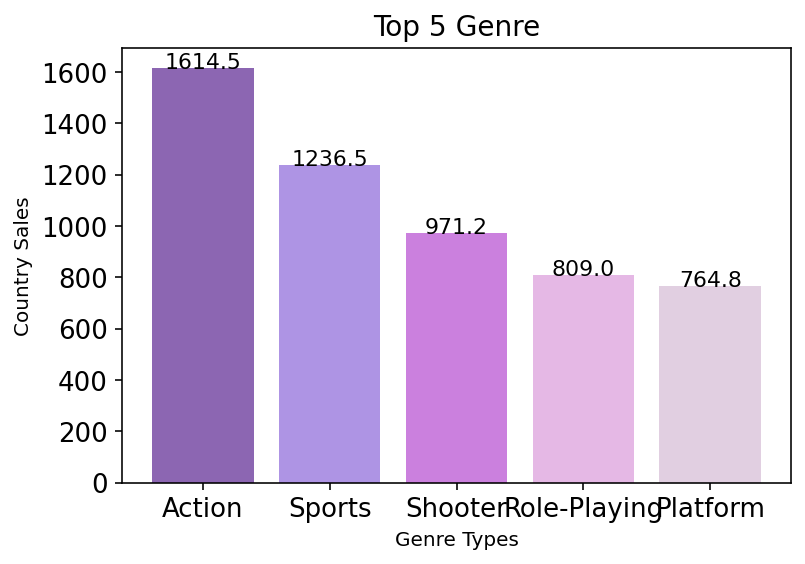

In [48]:
#유럽연합이 선호하는 장르 순위

df_Total = df.groupby(["Genre"],axis=0, sort = True).sum()["Total_sales"].sort_values(ascending = False).head(5)

## 시각화
tick_size = 13 ## 눈금 폰트 사이즈
axis_label_size = 10 ## x축, y축 폰트 사이즈
 
fig = plt.figure(figsize=(6,4)) ## Figure 생성 사이즈는 10 by 10
ax = fig.add_subplot() ## Axes 추가
# colors = sns.color_palette('hls',len(df_EU)) ## 색상 지정
 
xtick_label_position = list(range(len(df_Total))) ## x축 눈금 라벨이 표시될 x좌표
 
plt.yticks(fontsize=tick_size)
plt.xticks(xtick_label_position, df_Total.index, fontsize=tick_size) ## x축 눈금 라벨 출력
 
bars = plt.bar(xtick_label_position, df_Total, color=["rebeccapurple","mediumpurple","mediumorchid","plum","thistle"], alpha=0.75, linewidth=3) ## 바차트 출력
 
for i, b in enumerate(bars):
    ax.text(b.get_x()+b.get_width()*(1/2),b.get_height()+0.1, \
            round(df_Total[i],1),ha='center',fontsize=11)
    
plt.title('Top 5 Genre',fontsize=14) ## 타이틀 출력
plt.xlabel('Genre Types',fontsize=axis_label_size) ## x축 라벨 출력
plt.ylabel('Country Sales',fontsize=axis_label_size) ## y축 라벨 출력
plt.show()

##연도별 게임의 트렌드

In [49]:
#Year 'int' 타입으로 변환
df['Year'].astype('int64')

#년도 별 출고량이 가장 높은 장르
df_Year = pd.DataFrame(df.groupby(['Year','Genre'])["Total_sales"].sum()).reset_index().sort_values(by=["Year","Total_sales"],ascending=[True,False])
Table_Year = pd.pivot_table(df_Year, values="Total_sales", index=["Year"], columns="Genre") #pivot_table을 이용해서 테이블 만들기
Table_Year = Table_Year.iloc[:-1] # 마지막 행 데이터 부족으로 삭제
Table_Year = Table_Year.fillna(0) #nan값 0으로 대체
Table_Year.head(5)

Genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
Year,,,,,,,,,,,,
1980.0,0.34,0.0,0.77,2.47,0.00,0.00,0.00,0.0,7.07,0.00,0.00,0.0
1981.0,12.82,0.0,0.00,0.00,6.92,2.25,0.48,0.0,10.02,0.44,0.78,0.0
1982.0,6.50,0.0,0.00,0.87,5.03,10.04,1.57,0.0,3.81,0.00,1.06,0.0
1983.0,2.86,0.4,0.00,2.14,6.93,0.78,0.00,0.0,0.49,0.00,3.20,0.0
1984.0,1.85,0.0,0.00,1.45,0.69,3.14,4.43,0.0,31.10,0.00,6.17,0.0


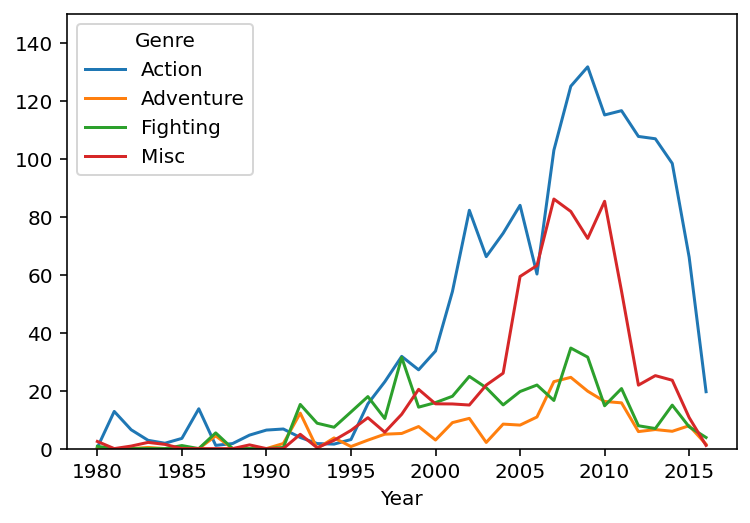

In [50]:
Table_Year.iloc[:,0:4].plot.line()
plt.ylim((0,150))
plt.show()

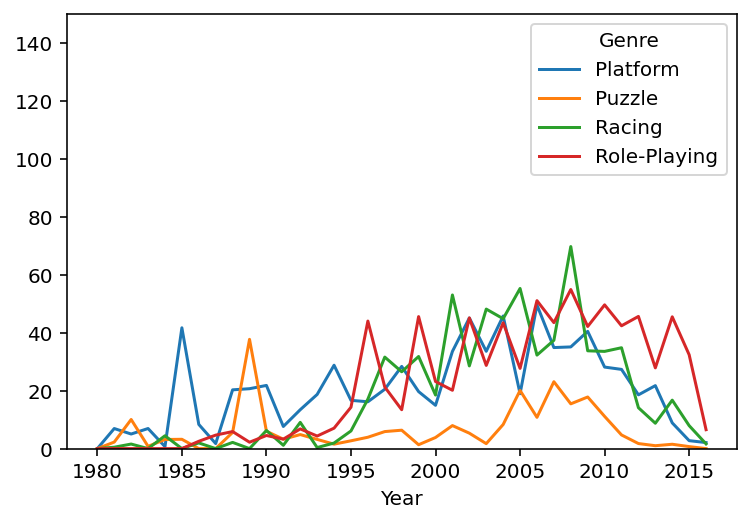

In [51]:
Table_Year.iloc[:,4:8].plot.line()
plt.ylim((0,150))
plt.show()

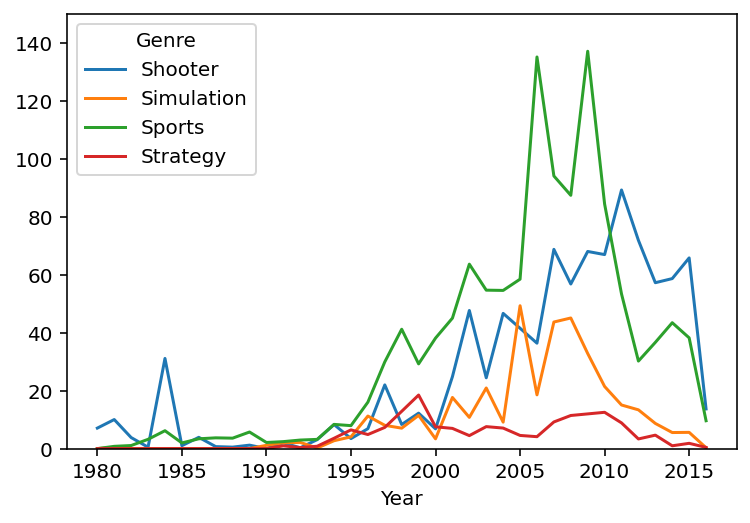

In [52]:
Table_Year.iloc[:,8:12].plot.line()
plt.ylim((0,150))
plt.show()

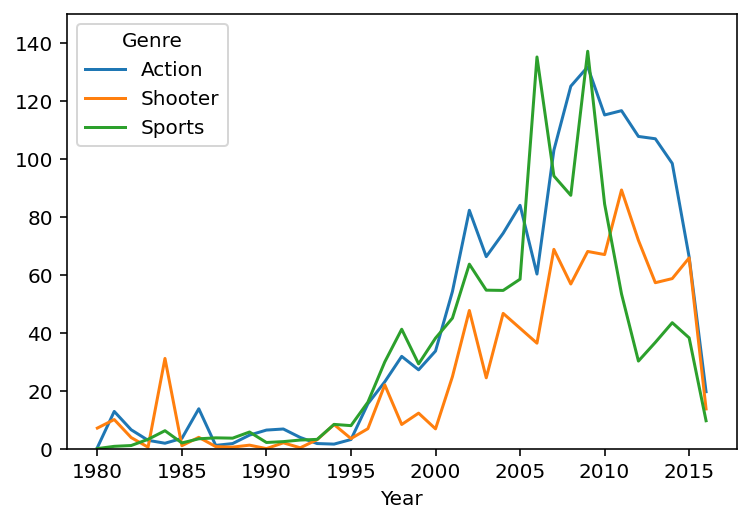

In [53]:
# Action	Adventure	Fighting	Misc	Platform	Puzzle	Racing	Role-Playing	Shooter	Simulation	Sports
Table_Year[["Action","Shooter","Sports"]].plot.line()
plt.ylim((0,150))
plt.show()

In [54]:
#년도 별 출고량이 가장 높은 장르
df_Year = pd.DataFrame(df.groupby(['Year','Genre'])["Total_sales"].sum()).reset_index().sort_values(by=["Year","Total_sales"],ascending=[True,False])
df_Year_Sum = df_Year.groupby(["Year"])["Total_sales"].sum().reset_index()
df_Year = df_Year.groupby("Year").head(1).reset_index(drop=True)

#Column 이름 바꿔주기
df_Year_Sum.rename(columns = {"Total_sales":"Sum_sales"},inplace=True)

#두 프레임 Merge
df_Year = pd.merge(df_Year, df_Year_Sum, on="Year")
df_Year.reset_index(drop=True)

df_Year["Proportion(%)"] = round(df_Year["Total_sales"]/(df_Year["Sum_sales"])*100,2)
df_Year = df_Year.iloc[:-1]

df_Year.head(5)

,Year,Genre,Total_sales,Sum_sales,Proportion(%)
0,1980.0,Shooter,7.07,10.65,66.38
1,1981.0,Action,12.82,33.71,38.03
2,1982.0,Puzzle,10.04,28.88,34.76
3,1983.0,Platform,6.93,16.80,41.25
4,1984.0,Shooter,31.10,48.83,63.69


In [55]:
df_Year_Prop = df_Year.iloc[:,[0,1,4]]
df_Year_Prop.head()

,Year,Genre,Proportion(%)
0,1980.0,Shooter,66.38
1,1981.0,Action,38.03
2,1982.0,Puzzle,34.76
3,1983.0,Platform,41.25
4,1984.0,Shooter,63.69


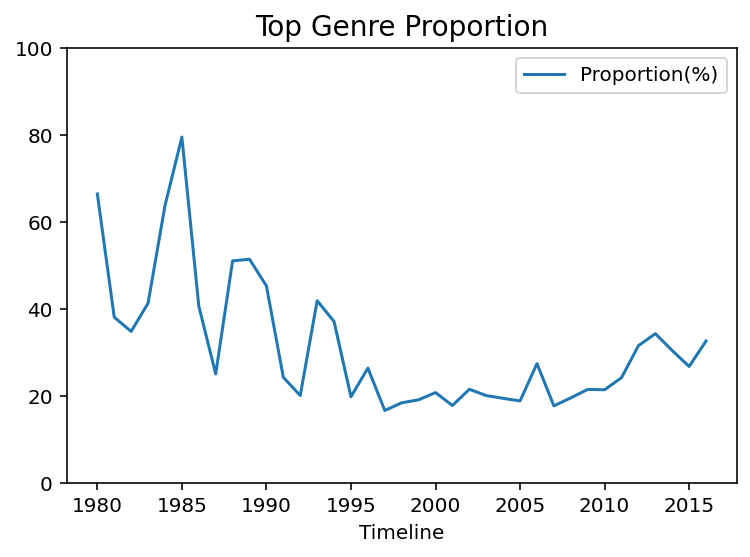

In [56]:
df_Year_Prop.plot.line(x="Year", y="Proportion(%)")
plt.title('Top Genre Proportion',fontsize=14) ## 타이틀 출력
plt.xlabel('Timeline',fontsize=axis_label_size) ## x축 라벨 출력
plt.ylim((0,100))
plt.show()

##출고량이 높은 게임에 대한 분석 및 시각화 프로세스

In [57]:
#출고량이 가장 높은 게임
df_Sales = pd.DataFrame(df.groupby(["Name","Genre","Platform","Publisher"])["Total_sales"].sum()).reset_index().sort_values(by=["Total_sales"],ascending=[False])
df_Sales.head(5)

,Name,Genre,Platform,Publisher,Total_sales
14765,Wii Sports,Sports,Wii,Nintendo,82.74
12395,Super Mario Bros.,Platform,NES,Nintendo,40.24
7369,Mario Kart Wii,Racing,Wii,Nintendo,35.83
14767,Wii Sports Resort,Sports,Wii,Nintendo,33.00
9756,Pokemon Red/Pokemon Blue,Role-Playing,GB,Nintendo,31.38


In [58]:
df_Sales.describe()

,Total_sales
count,15379.000000
mean,0.535985
std,1.568703
min,0.010000
25%,0.060000
50%,0.170000
75%,0.480000
max,82.740000


In [59]:
#데이터의 상위 25%, 10%, 1%, 0.1% 를 각각 나누어서 새로운 데이터에 담는다.
df_Sales_All = df_Sales
df_Sales_25p = df_Sales.head(round(len(df_Sales)*0.25))
df_Sales_10p = df_Sales.head(round(len(df_Sales)*0.1))
df_Sales_1p = df_Sales.head(round(len(df_Sales)*0.01))
df_Sales_01p = df_Sales.head(round(len(df_Sales)*0.001))
df_Sales_All.head()


,Name,Genre,Platform,Publisher,Total_sales
14765,Wii Sports,Sports,Wii,Nintendo,82.74
12395,Super Mario Bros.,Platform,NES,Nintendo,40.24
7369,Mario Kart Wii,Racing,Wii,Nintendo,35.83
14767,Wii Sports Resort,Sports,Wii,Nintendo,33.00
9756,Pokemon Red/Pokemon Blue,Role-Playing,GB,Nintendo,31.38


In [60]:
#출고량이 높은 각각의 데이터들의 장르별 출고량을 나타낸 데이터 프레임 만들기
df_Sales_All_Genre = df_Sales_All.groupby("Genre")["Total_sales"].sum().reset_index().sort_values(by=["Total_sales"],ascending=[False])
df_Sales_25p_Genre = df_Sales_25p.groupby("Genre")["Total_sales"].sum().reset_index().sort_values(by=["Total_sales"],ascending=[False])
df_Sales_10p_Genre = df_Sales_10p.groupby("Genre")["Total_sales"].sum().reset_index().sort_values(by=["Total_sales"],ascending=[False])
df_Sales_1p_Genre = df_Sales_1p.groupby("Genre")["Total_sales"].sum().reset_index().sort_values(by=["Total_sales"],ascending=[False])
df_Sales_01p_Genre = df_Sales_01p.groupby("Genre")["Total_sales"].sum().reset_index().sort_values(by=["Total_sales"],ascending=[False])
df_Sales_All_Genre.head()

,Genre,Total_sales
0,Action,1614.48
10,Sports,1236.50
8,Shooter,971.22
7,Role-Playing,808.97
4,Platform,764.83


In [61]:
df_Sales_Genre = pd.merge(df_Sales_25p_Genre, df_Sales_10p_Genre, on="Genre", suffixes=('_25', '_10'))
df_Sales_Genre = pd.merge(df_Sales_Genre, df_Sales_1p_Genre, on="Genre", suffixes=('_10', '_1'))
df_Sales_Genre = pd.merge(df_Sales_Genre, df_Sales_01p_Genre, on="Genre", suffixes=('_1', '_01'))
df_Sales_Genre.rename(columns = {"Total_sales_25":"25(%)","Total_sales_10":"10(%)","Total_sales_1":"1(%)","Total_sales_01":"0.1(%)"}, inplace=True)
df_Sales_Genre.set_index("Genre",inplace = True)
df_Sales_Genre

,25(%),10(%),1(%),0.1(%)
Genre,,,,
Sports,974.11,663.39,210.24,160.46
Shooter,853.70,677.84,311.45,28.31
Platform,679.83,564.48,282.33,98.86
Role-Playing,661.56,507.94,192.16,54.47
Misc,564.68,414.00,143.75,29.01
Racing,554.70,409.28,177.08,59.26
Simulation,281.81,193.65,59.96,24.75
Puzzle,185.20,142.63,64.29,30.26


In [62]:
# df_Sales_Genre_top4 = df_Sales_Genre.iloc[:4]
# df_Sales_Genre_top4

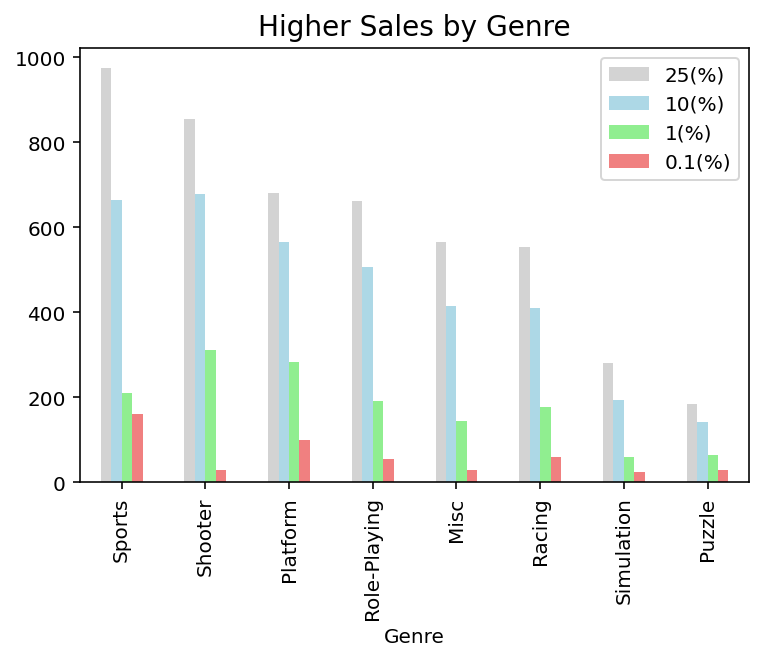

In [63]:
df_Sales_Genre.plot.bar(color=["lightgray","lightblue","lightgreen","lightcoral"])
plt.title('Higher Sales by Genre',fontsize=14) ## 타이틀 출력
plt.show()

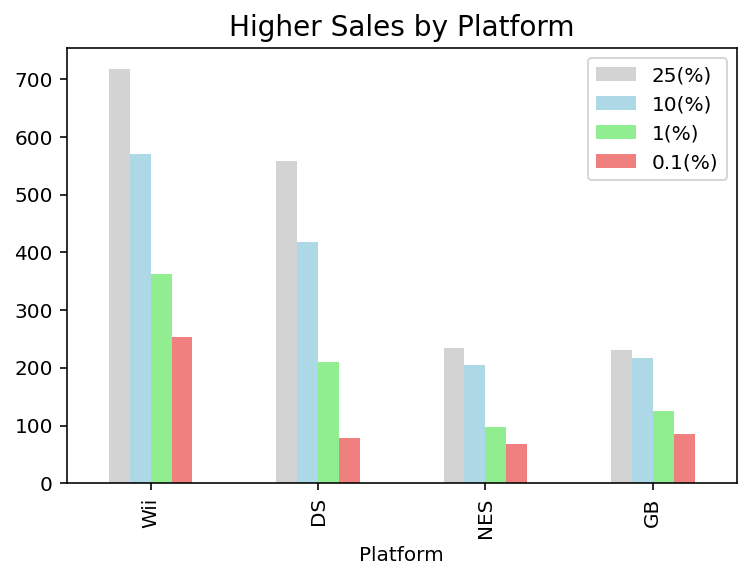

In [64]:
#출고량이 높은 각각의 데이터들을 출판사별 출고량을 나타낸 데이터 프레임 만들기
df_Sales_All_Platform = df_Sales_All.groupby("Platform")["Total_sales"].sum().reset_index().sort_values(by=["Total_sales"],ascending=[False])
df_Sales_25p_Platform = df_Sales_25p.groupby("Platform")["Total_sales"].sum().reset_index().sort_values(by=["Total_sales"],ascending=[False])
df_Sales_10p_Platform = df_Sales_10p.groupby("Platform")["Total_sales"].sum().reset_index().sort_values(by=["Total_sales"],ascending=[False])
df_Sales_1p_Platform = df_Sales_1p.groupby("Platform")["Total_sales"].sum().reset_index().sort_values(by=["Total_sales"],ascending=[False])
df_Sales_01p_Platform = df_Sales_01p.groupby("Platform")["Total_sales"].sum().reset_index().sort_values(by=["Total_sales"],ascending=[False])
df_Sales_01p_Platform.head()

#여러개의 데이터 프레임 Merge 해주기
df_Sales_Platform = pd.merge(df_Sales_25p_Platform, df_Sales_10p_Platform, on="Platform", suffixes=('_25', '_10'))
df_Sales_Platform = pd.merge(df_Sales_Platform, df_Sales_1p_Platform, on="Platform", suffixes=('_10', '_1'))
df_Sales_Platform = pd.merge(df_Sales_Platform, df_Sales_01p_Platform, on="Platform", suffixes=('_1', '_01'))
df_Sales_Platform.rename(columns = {"Total_sales_25":"25(%)","Total_sales_10":"10(%)","Total_sales_1":"1(%)","Total_sales_01":"0.1(%)"}, inplace=True)
df_Sales_Platform.set_index("Platform",inplace = True)
df_Sales_Platform

#bar plot으로 시각화
df_Sales_Platform.plot.bar(color=["lightgray","lightblue","lightgreen","lightcoral"])
plt.title('Higher Sales by Platform',fontsize=14) ## 타이틀 출력
plt.show()

In [65]:
#출고량이 높은 각각의 데이터들을 플렛폼별 출고량을 나타낸 데이터 프레임 만들기
df_Sales_All_Publisher = df_Sales_All.groupby("Publisher")["Total_sales"].sum().reset_index().sort_values(by=["Total_sales"],ascending=[False])
df_Sales_25p_Publisher = df_Sales_25p.groupby("Publisher")["Total_sales"].sum().reset_index().sort_values(by=["Total_sales"],ascending=[False])
df_Sales_10p_Publisher = df_Sales_10p.groupby("Publisher")["Total_sales"].sum().reset_index().sort_values(by=["Total_sales"],ascending=[False])
df_Sales_1p_Publisher = df_Sales_1p.groupby("Publisher")["Total_sales"].sum().reset_index().sort_values(by=["Total_sales"],ascending=[False])
df_Sales_01p_Publisher = df_Sales_01p.groupby("Publisher")["Total_sales"].sum().reset_index().sort_values(by=["Total_sales"],ascending=[False])
df_Sales_01p_Publisher.head()

df_Sales_25p_Publisher.rename(columns = {"Total_sales":"25(%)"},inplace=True)
df_Sales_10p_Publisher.rename(columns = {"Total_sales":"10(%)"},inplace=True)
df_Sales_1p_Publisher.rename(columns = {"Total_sales":"1(%)"},inplace=True)
df_Sales_01p_Publisher.rename(columns = {"Total_sales":"0.1(%)"},inplace=True)

#여러개의 데이터 프레임 Merge 해주기
df_Sales_Publisher = pd.merge(df_Sales_25p_Publisher, df_Sales_10p_Publisher, how="outer", suffixes=('_25', '_10'))
df_Sales_Publisher = pd.merge(df_Sales_Publisher, df_Sales_1p_Publisher, how="outer", suffixes=('_10', '_1'))
df_Sales_Publisher = pd.merge(df_Sales_Publisher, df_Sales_01p_Publisher, how="outer", suffixes=('_1', '_01'))
df_Sales_Publisher.rename(columns = {"Total_sales_25":"25(%)","Total_sales_10":"10(%)","Total_sales_1":"1(%)","Total_sales_01":"0.1(%)"}, inplace=True)
df_Sales_Publisher.set_index("Publisher",inplace = True)
df_Sales_Publisher


,25(%),10(%),1(%),0.1(%)
Publisher,,,,
Nintendo,1602.04,1484.40,931.59,485.38
Electronic Arts,885.24,605.67,80.88,NaN
Activision,571.38,430.93,197.31,NaN
Sony Computer Entertainment,506.73,390.68,141.32,NaN
Ubisoft,347.96,226.19,45.09,NaN
...,...,...,...,...
Answer Software,0.50,NaN,NaN,NaN
Rebellion,0.48,NaN,NaN,NaN
XS Games,0.48,NaN,NaN,NaN


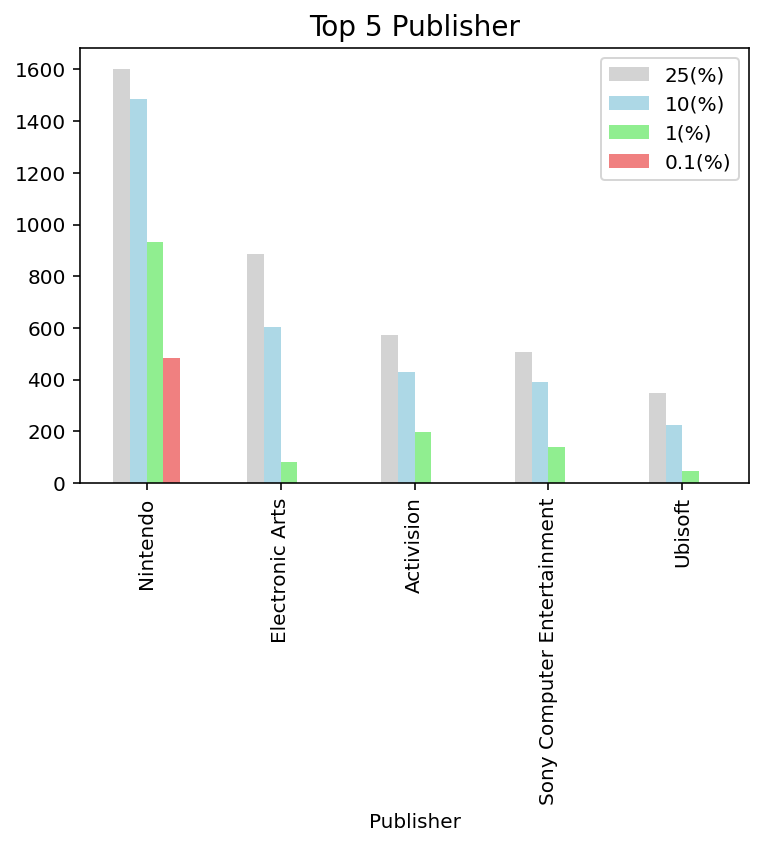

In [66]:
#Top 10 publisher
df_Sales_Publisher = df_Sales_Publisher.iloc[0:5]

#bar plot으로 시각화
df_Sales_Publisher.plot.bar(color=["lightgray","lightblue","lightgreen","lightcoral"])
plt.title('Top 5 Publisher',fontsize=14) ## 타이틀 출력
plt.show()

In [67]:
# #플렛폼별 게임 갯수 top10
# print("플렛폼별 게임 카운트 top10")
# print(df['Platform'].value_counts().head(10),"\n")

# #플렛폼 별 토탈 게임 출고량 순 top10
# print("플렛폼 별 토탈 게임 출고량 순 top10")
# print(df.groupby(['Platform']).sum()["Total_sales"].sort_values(ascending = False).head(10))